In [38]:
names = ['achilles', 'buddy', 'gatsby', 'cicero']
dims = [8,16,32,64]

In [44]:
import os
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from sae_architectures import *
from sae_eval_utils import compute_explained_variance, compute_l0_sparsity, get_nonzero_ratio
import pandas as pd
import seaborn as sns

dfs = {}

def get_model(arch, input_dim, exp, l1, topk=None, bw=None):
    if arch == "standard":
        return StandardSAE(input_dim, expansion_factor=exp, sparsity_lambda=l1)
    if arch == "topk":
        return TopKSAE(input_dim, expansion_factor=exp, topk=topk)
    if arch == "jumprelu":
        return JumpReLUSAE(input_dim, expansion_factor=exp, bandwidth=bw, sparsity_lambda=l1)
    if arch == "gated":
        return GatedSAE(input_dim, expansion_factor=exp, sparsity_lambda=l1)

def get_df(name, dim, arch_filter=None):
    embedding_path = f"../final_embeddings/output_dimension_{dim}_{name}/train_embeddings.npy"
    model_dir = f"../sae_gridsearch_2/{name}_{dim}"

    emb = np.load(embedding_path)
    input_dim = emb.shape[1]
    data_tensor = torch.tensor(emb).float()

    results = []

    for fname in os.listdir(model_dir):
        if not fname.endswith("_model.pt"):
            continue

        pattern = r"(?P<arch>\w+)_exp(?P<exp>\d+)_lr(?P<lr>[\d\.e-]+)_l1(?P<l1>[\d\.e-]+)(?:_topk(?P<topk>\d+))?(?:_bw(?P<bw>[\d\.e-]+))?_model.pt"
        match = re.match(pattern, fname)
        if not match:
            print(f"Skipping invalid filename: {fname}")
            continue

        arch = match.group("arch")
        if arch_filter and arch not in arch_filter:
            continue

        exp = int(match.group("exp"))
        lr = float(match.group("lr"))
        l1 = float(match.group("l1"))
        topk = int(match.group("topk")) if match.group("topk") else None
        bw = float(match.group("bw")) if match.group("bw") else None

        model = get_model(arch, input_dim, exp, l1=l1, topk=topk, bw=bw)
        model_path = os.path.join(model_dir, fname)
        model.load_state_dict(torch.load(model_path, map_location='cpu', weights_only=True))
        model.eval()

        with torch.no_grad():
            recon, latents, _ = model(data_tensor)
            recon = recon.numpy()
            latents = latents.numpy()

        r2 = compute_explained_variance(emb, recon)
        l0 = compute_l0_sparsity(latents)
        nz_ratio = get_nonzero_ratio(latents)

        results.append({
            "arch": arch,
            "exp": exp,
            "lr": lr,
            "l1": l1,
            "topk": topk,
            "bw": bw,
            "r2": r2,
            "l0": l0,
            "nz_ratio": nz_ratio
        })

    df = pd.DataFrame(results)

    return df


In [87]:
dfs['gatsby', 8][(dfs['gatsby', 8].arch == 'jumprelu') & (dfs['gatsby', 8].exp == 8)].describe()

,exp,lr,l1,topk,bw,r2,l0,nz_ratio
count,27.0,27.000000,27.000000,0.0,27.000000,27.000000,27.000000,27.000000
mean,8.0,0.000467,0.003700,NaN,0.002167,0.429909,0.268238,0.153060
std,0.0,0.000393,0.004555,NaN,0.002052,0.283814,0.411617,0.136374
min,8.0,0.000100,0.000100,NaN,0.000500,-0.000011,0.000000,0.000003
25%,8.0,0.000100,0.000100,NaN,0.000500,0.151441,0.000000,0.009758
50%,8.0,0.000300,0.001000,NaN,0.001000,0.548550,0.000000,0.148793
75%,8.0,0.001000,0.010000,NaN,0.005000,0.649547,0.511821,0.290619
max,8.0,0.001000,0.010000,NaN,0.005000,0.744956,0.999780,0.402066


In [45]:
for name in names:
    for dim in dims:
        df = get_df(name, dim)
        dfs[(name,dim)] = df

In [71]:
def exvvsnz_plot(name, dim):
    df = dfs[(name,dim)]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="nz_ratio", y="r2", hue="arch", style="exp", s=100)
    plt.title(f"Explained Variance vs Sparsity: {name}, dim={dim}")
    plt.xlabel("Non-zero Ratio")
    plt.ylabel("Explained Variance (R2)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

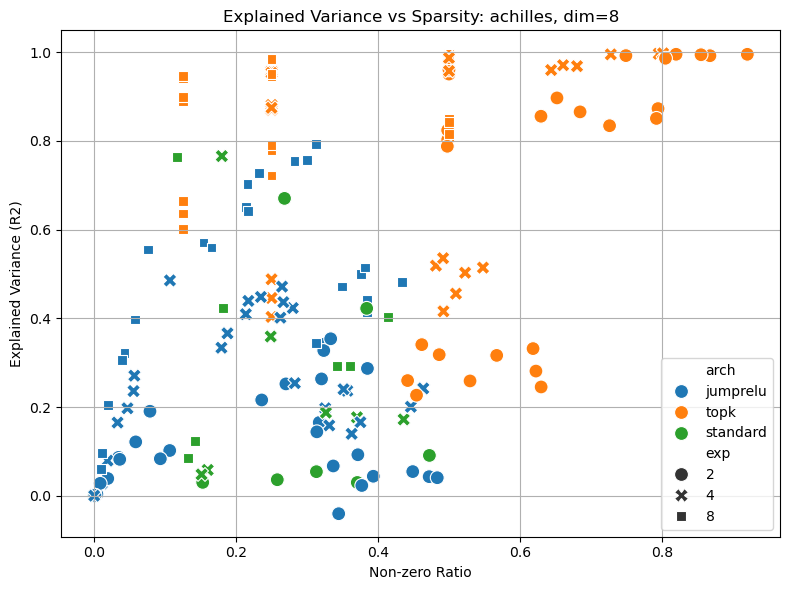

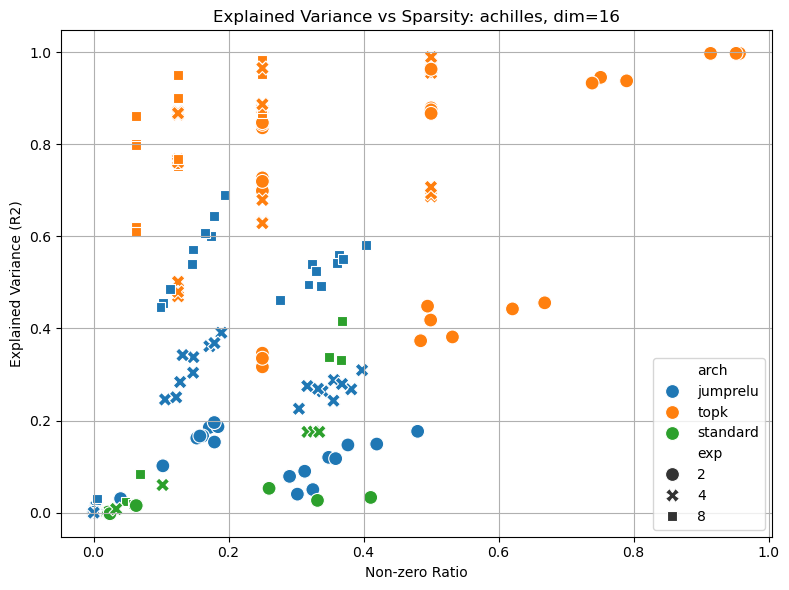

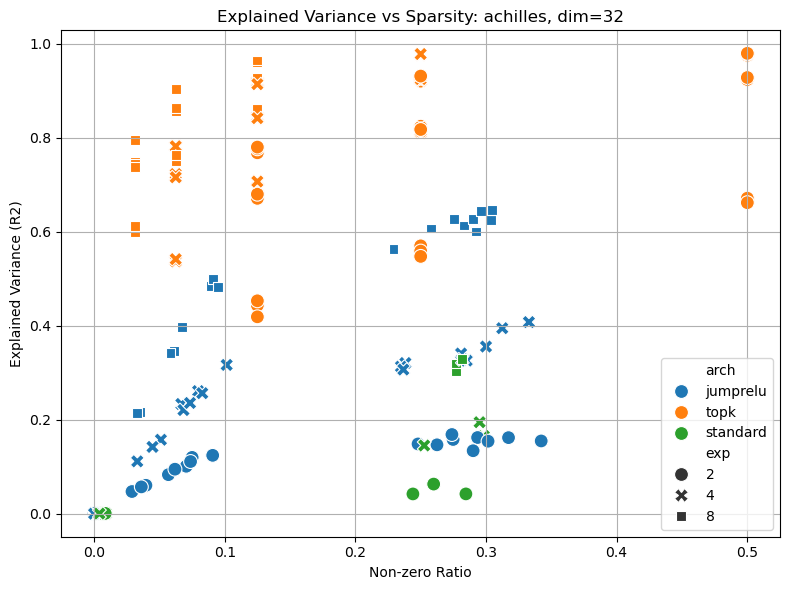

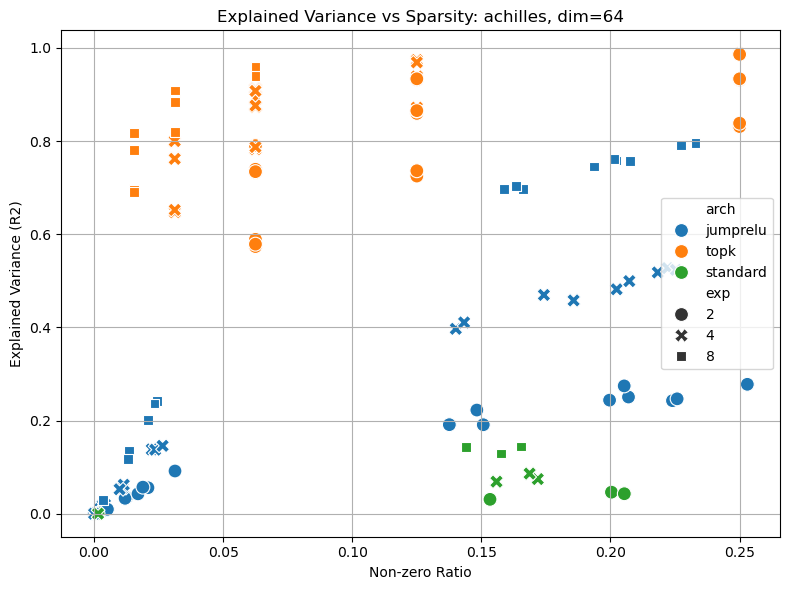

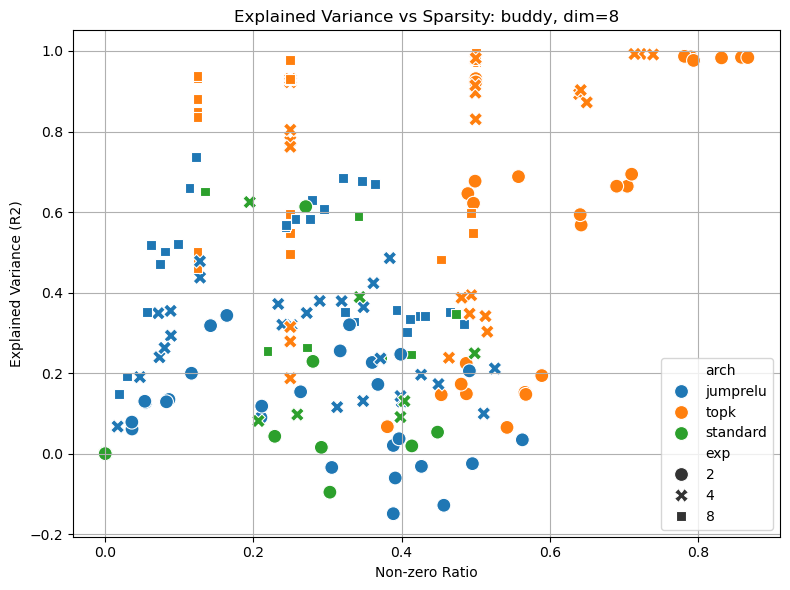

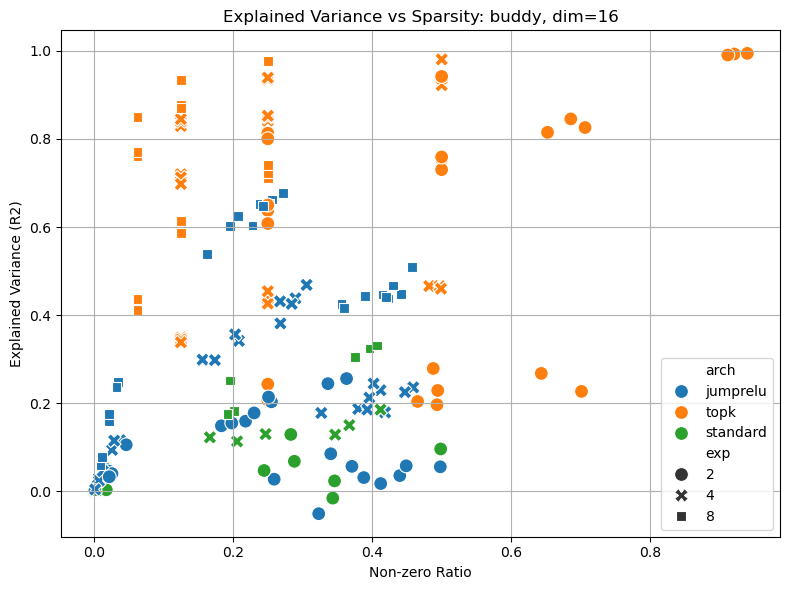

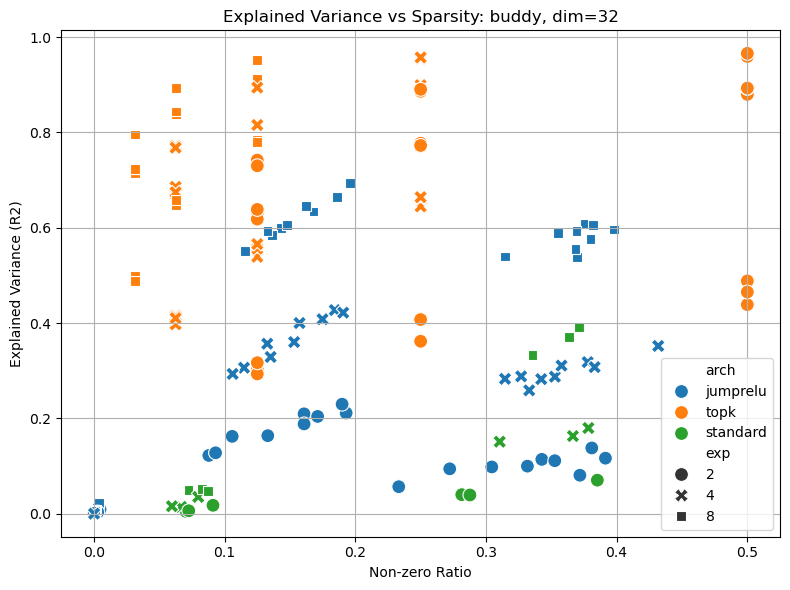

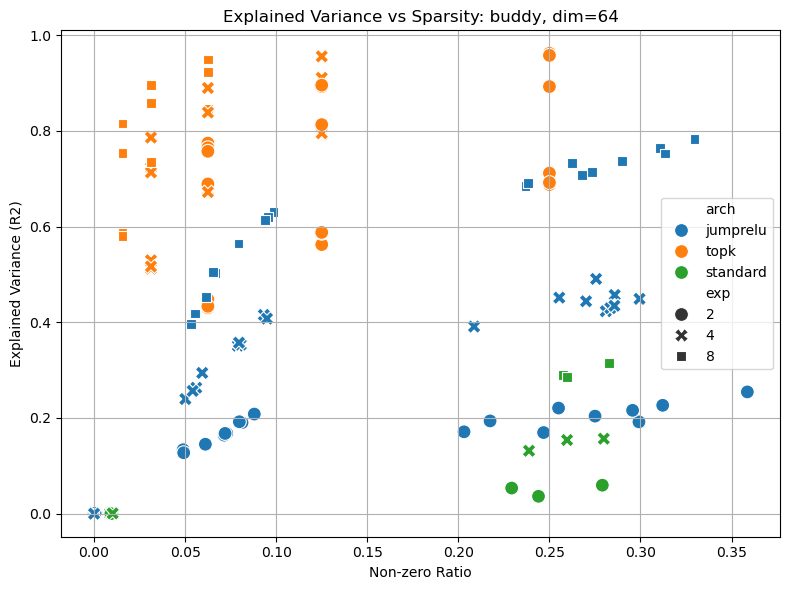

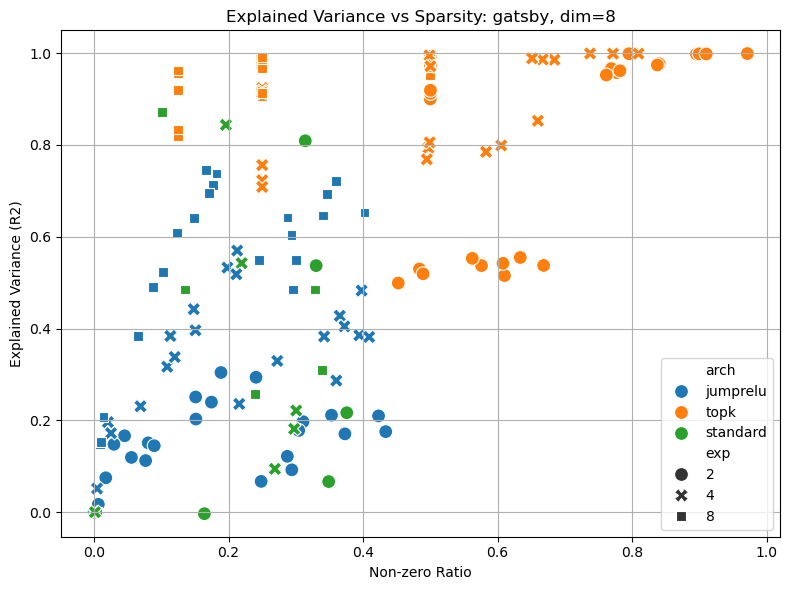

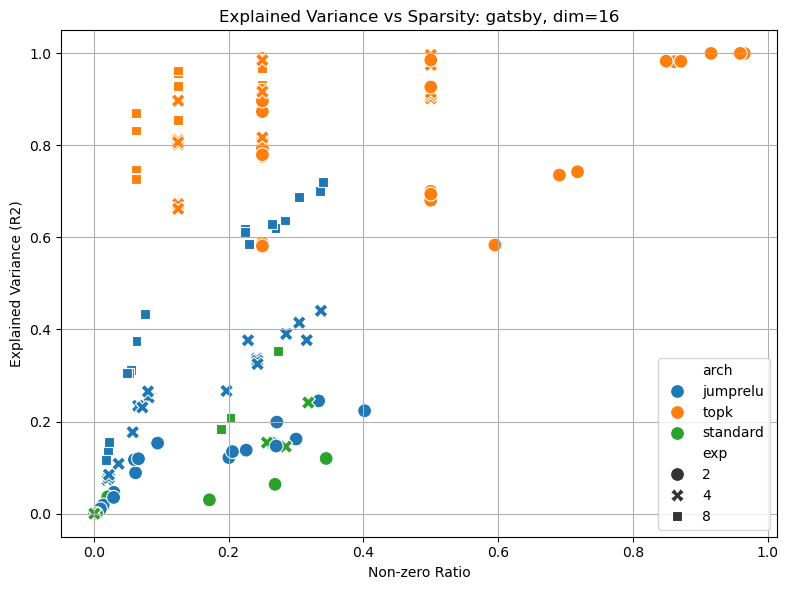

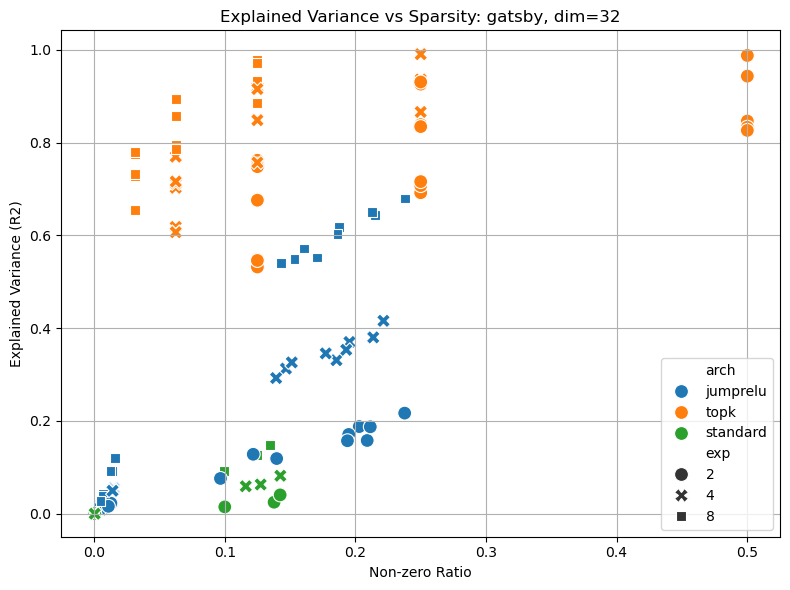

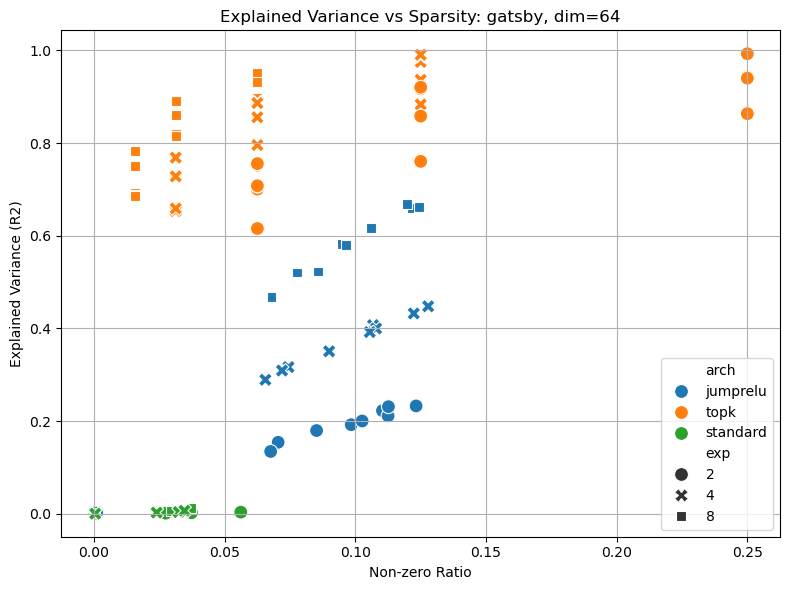

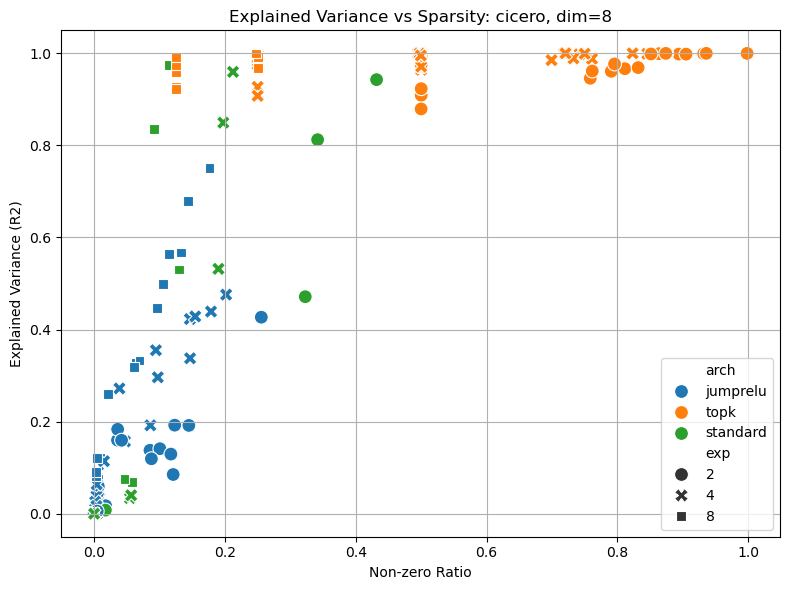

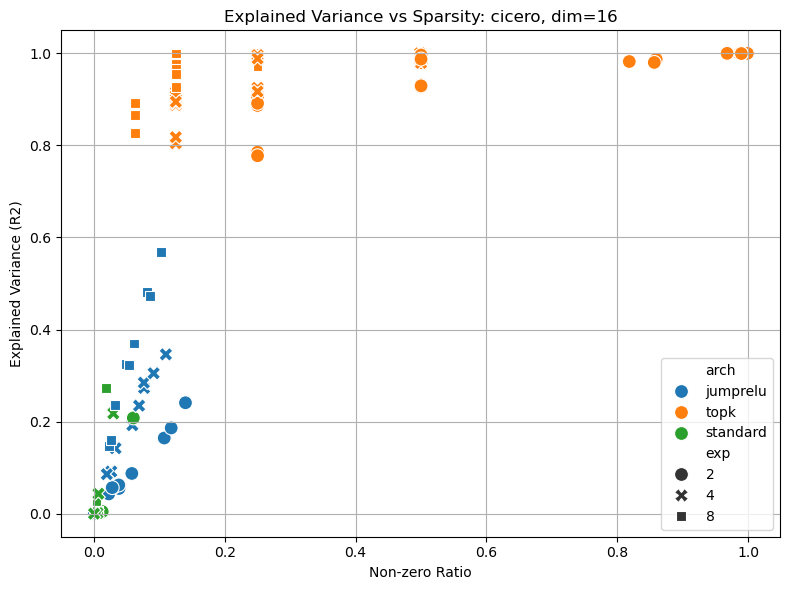

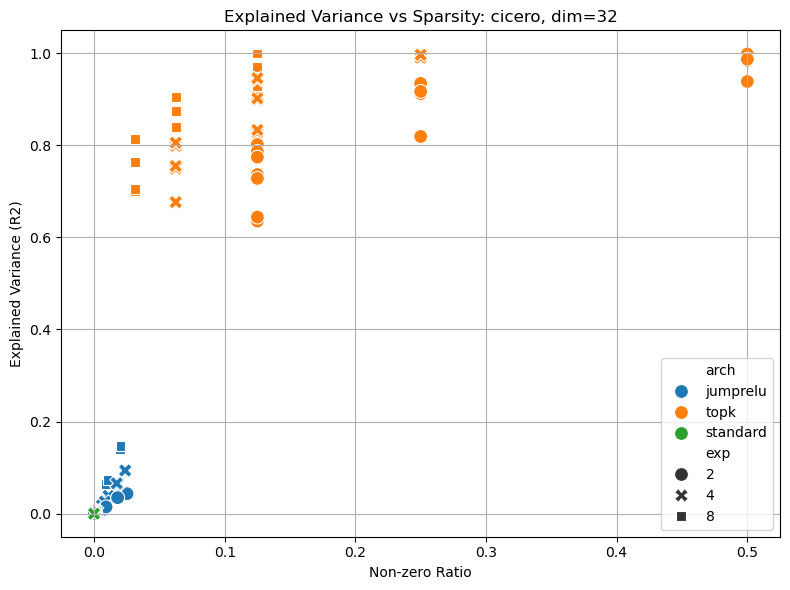

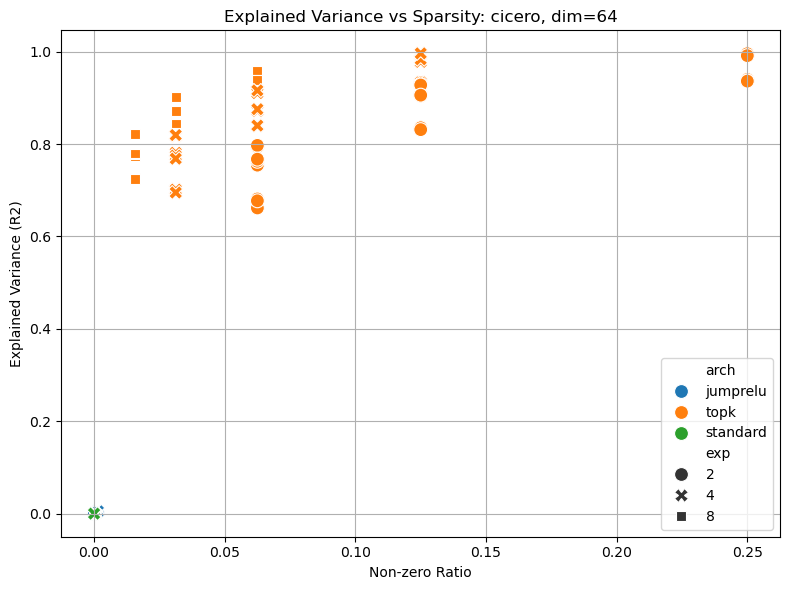

In [72]:
for name in names:
    for dim in dims:
        exvvsnz_plot(name, dim)

In [65]:
def topk_hyperparam_plot(name, dim, exp=8):
    arch="topk"
    df = dfs[(name, dim)]
    df = df[(df["arch"] == arch) & (df["exp"] == exp)]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="nz_ratio",
        y="r2",
        hue="topk",
        style="lr",
        s=100
    )
    plt.title(f"TopK Hyperparam Selection: {name}, dim={dim}, exp={exp}")
    plt.xlabel("Non-zero Ratio")
    plt.ylabel("Explained Variance (R2)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df.sort_values(by="r2", ascending=False)


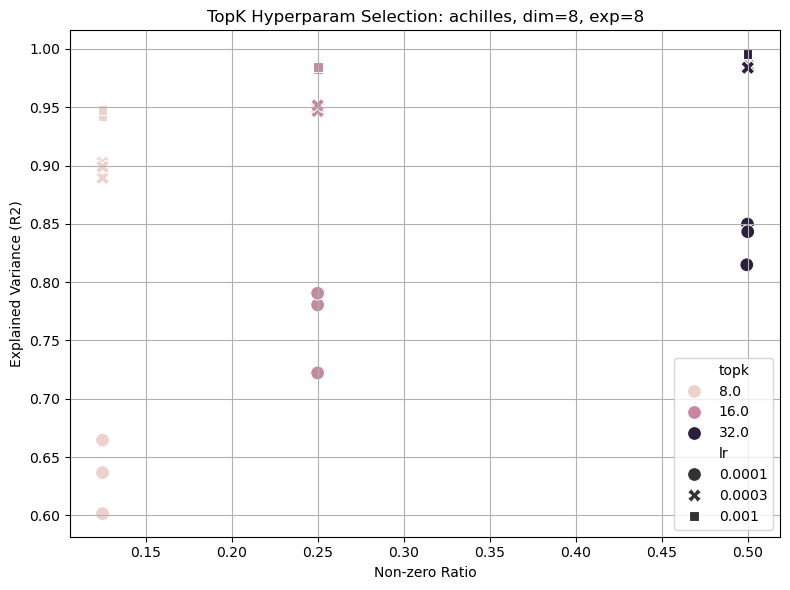

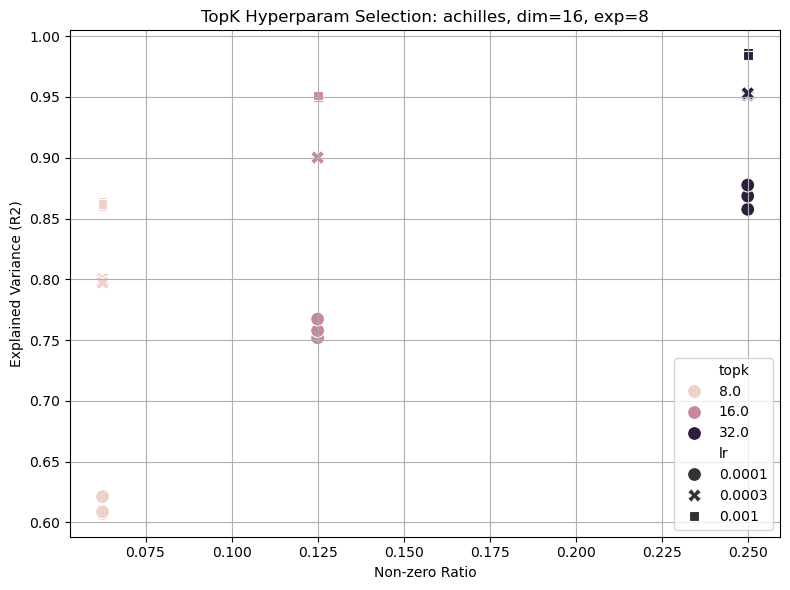

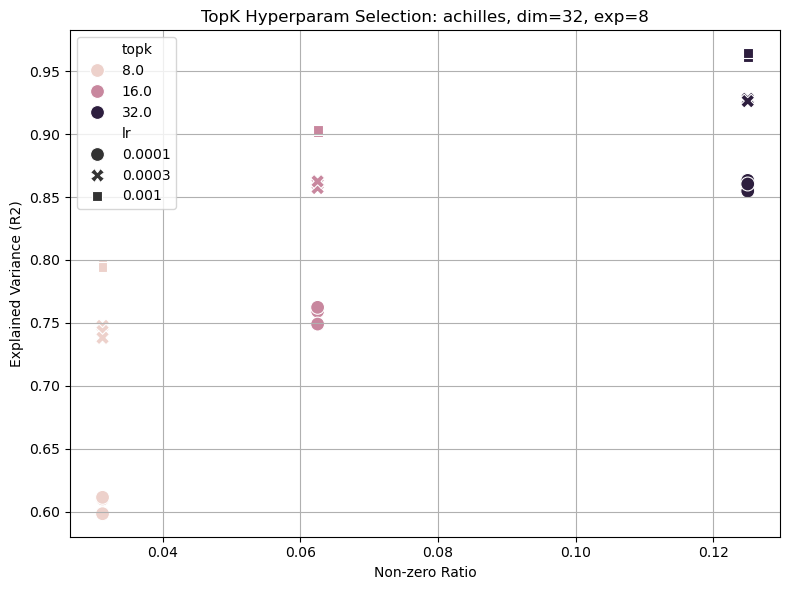

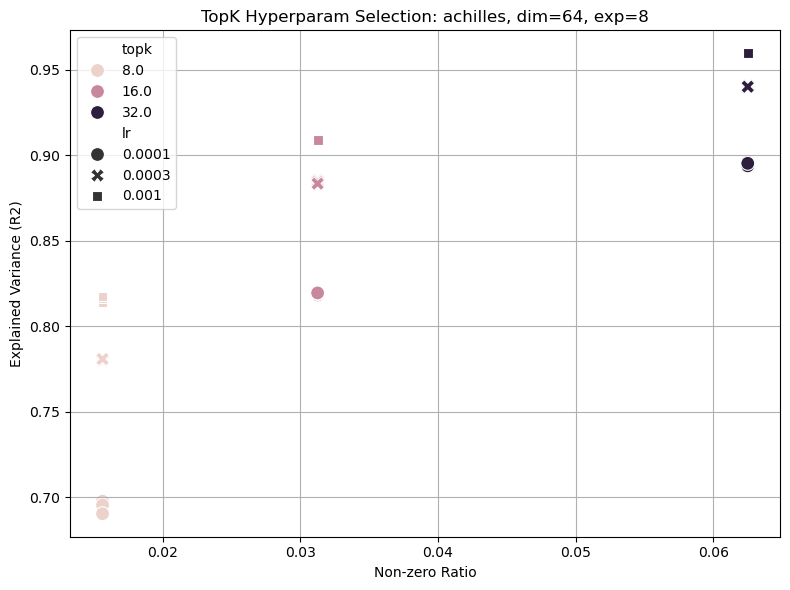

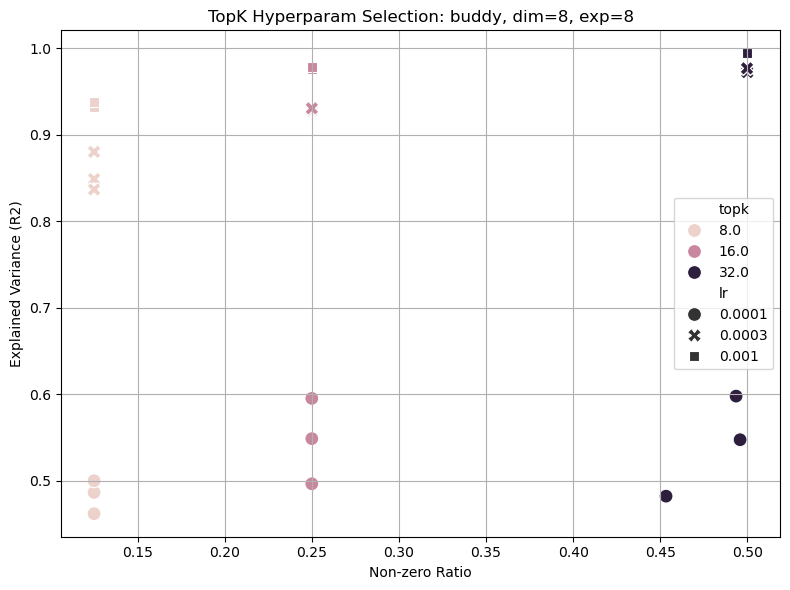

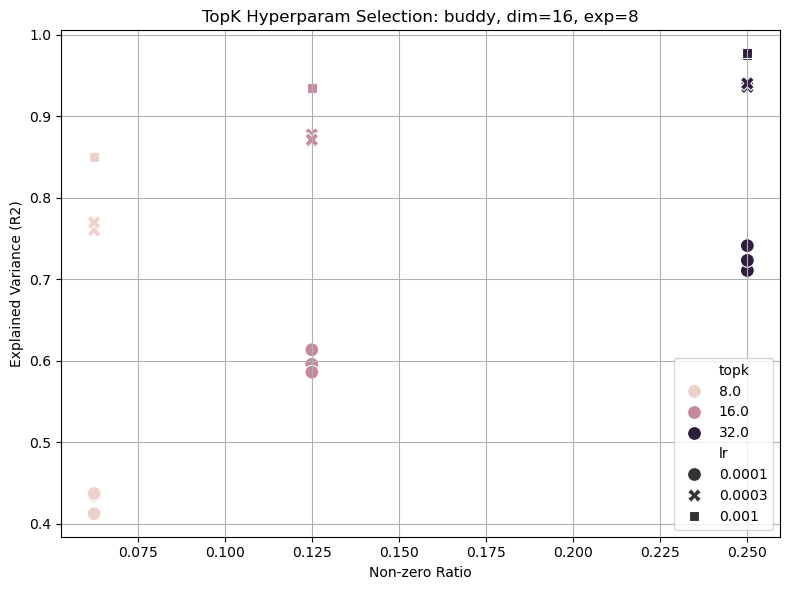

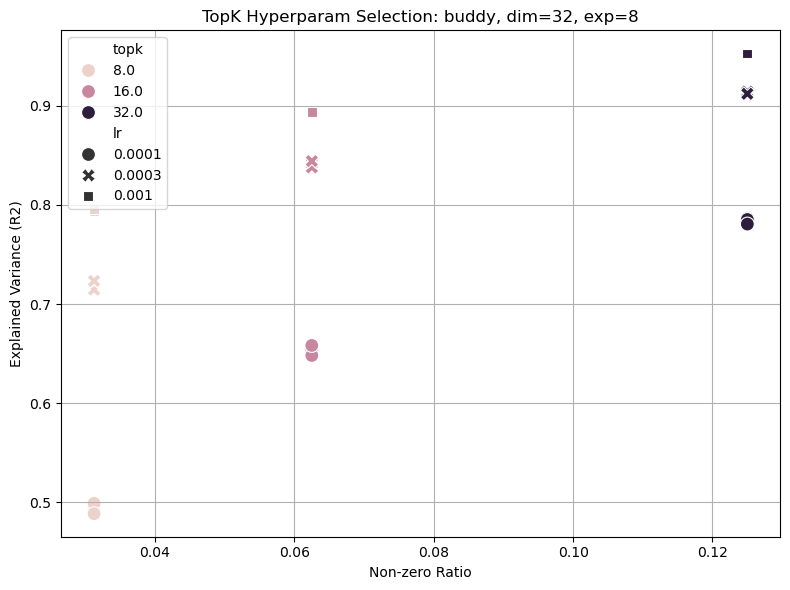

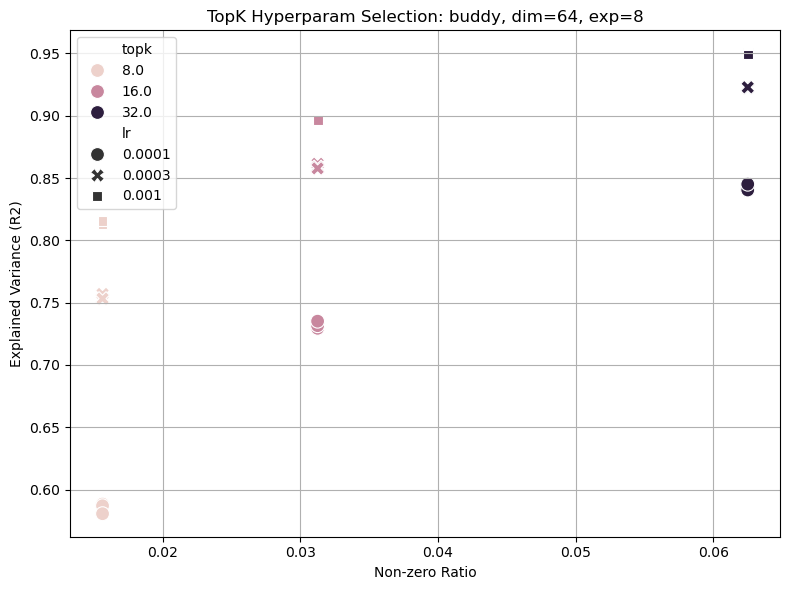

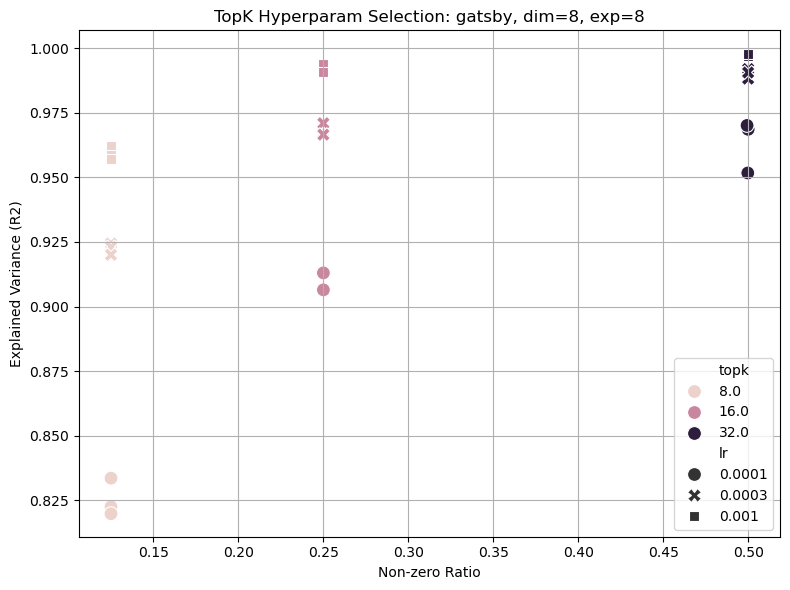

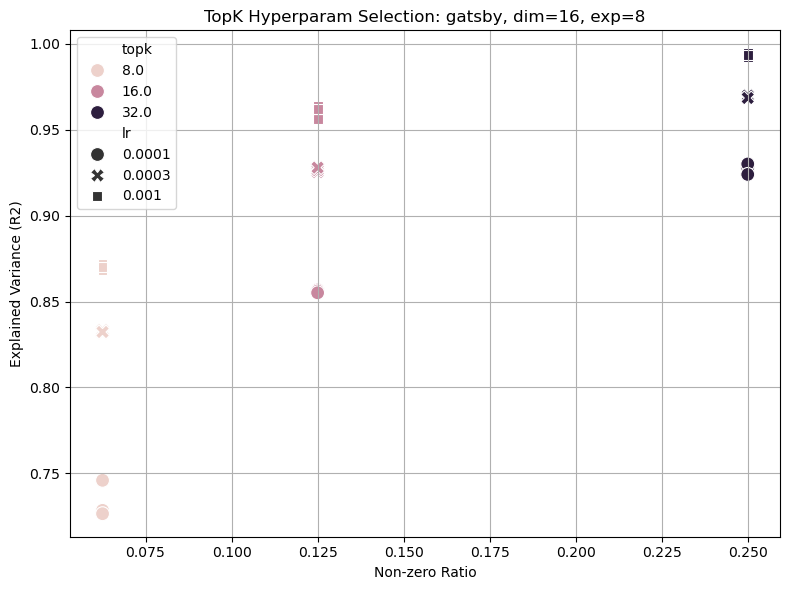

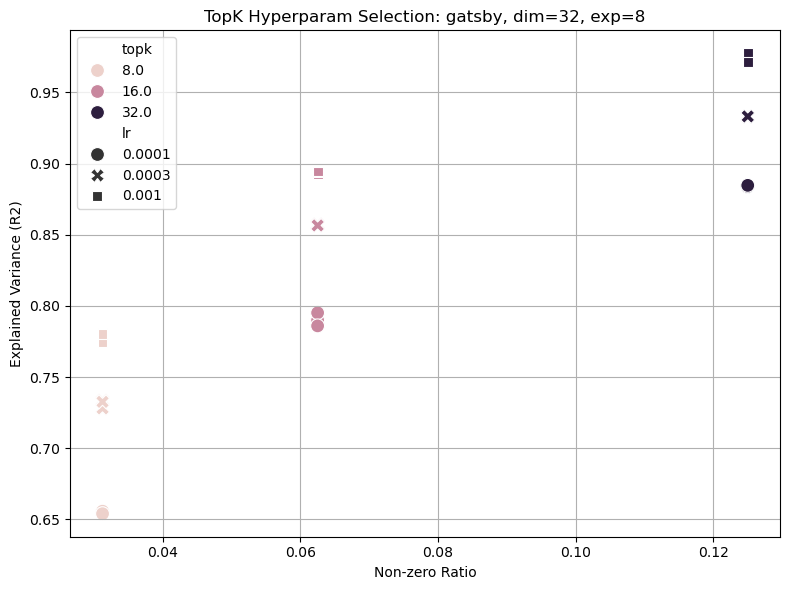

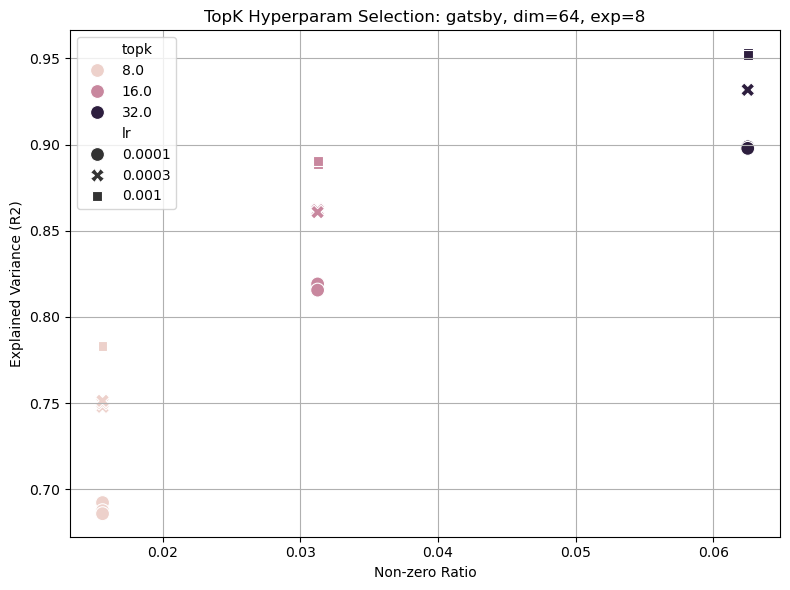

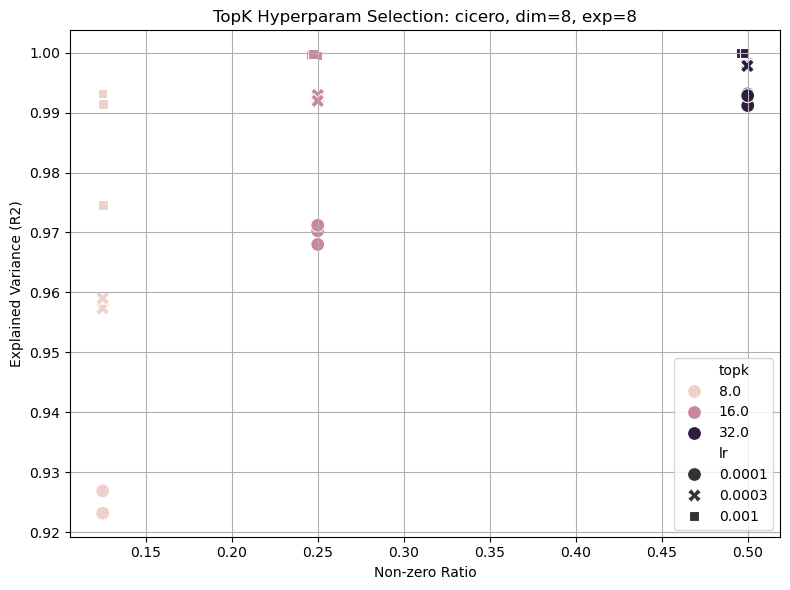

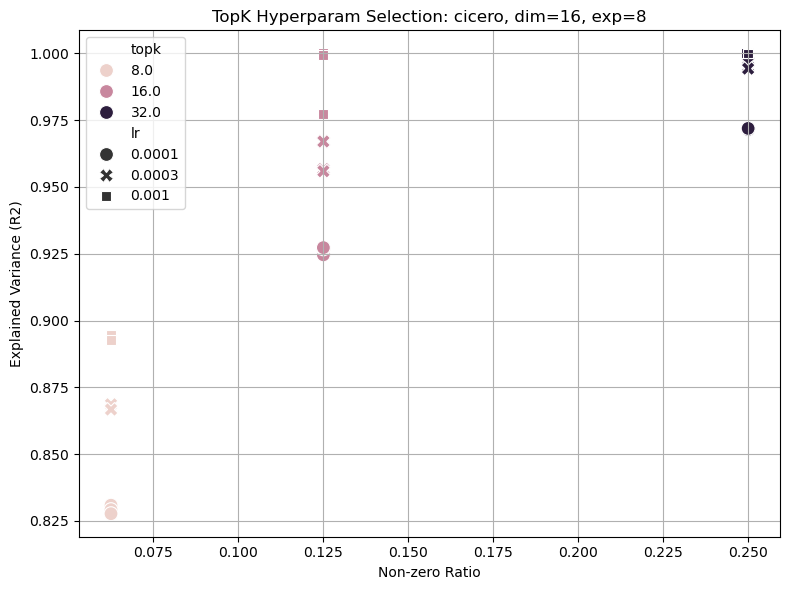

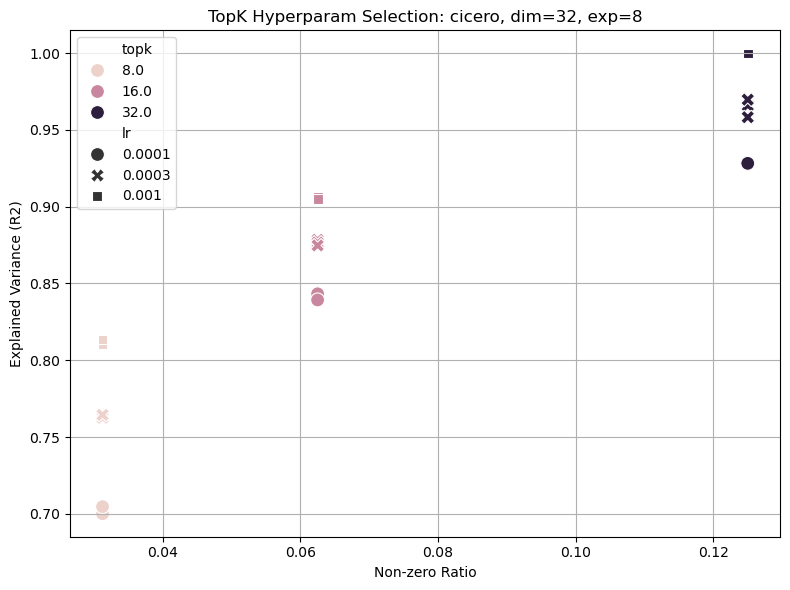

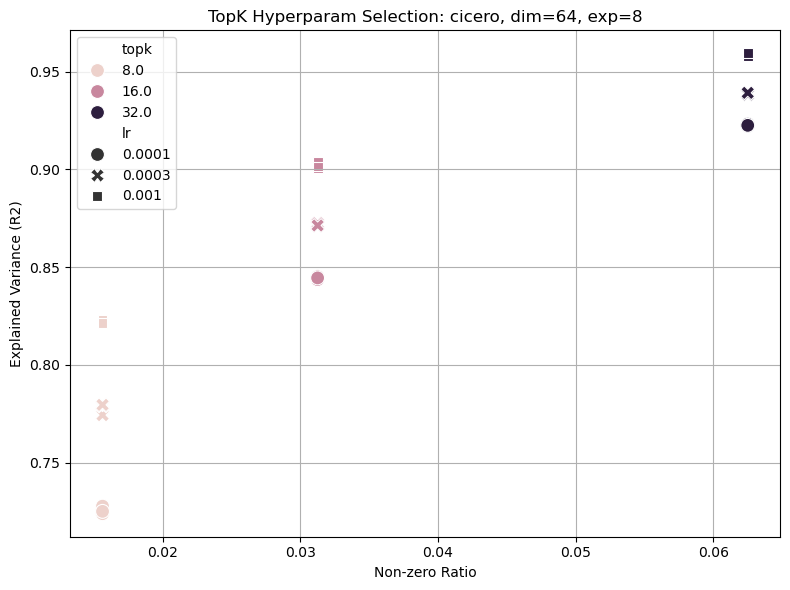

In [66]:
for name in names:
    for dim in dims:
        topk_hyperparam_plot(name, dim)

In [88]:
def bw_selection_plot(name, dim, expansion_factor=8):
    df_jr = df[(df["arch"] == "jumprelu") & (df["exp"] == expansion_factor)]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_jr,
        x="nz_ratio", y="r2",
        style="bw", hue="l1",
        palette="viridis", s = 100
    )
    plt.title(f"Non-zero Ratio vs Explained Variance (JumpReLU): {name}, dim={dim}, exp={expansion_factor}")
    plt.xlabel("Non-zero Ratio")
    plt.ylabel("Explained Variance (R2)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

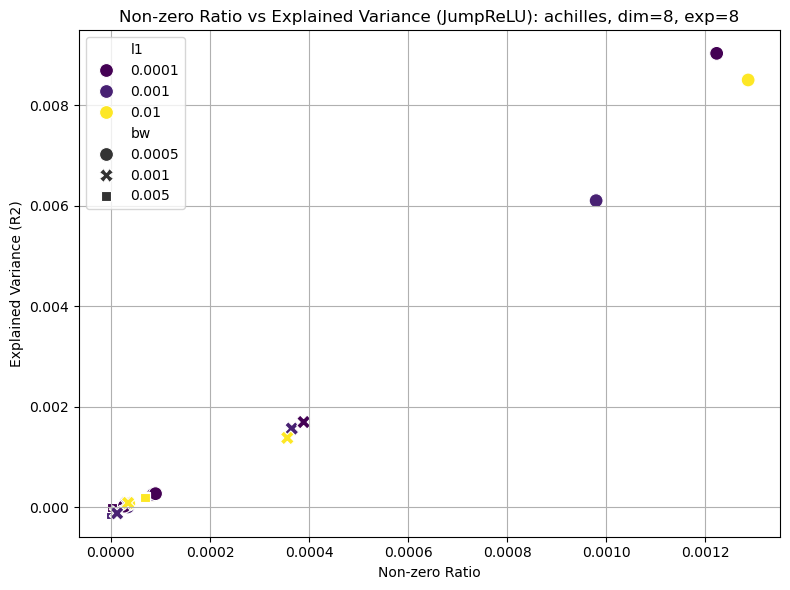

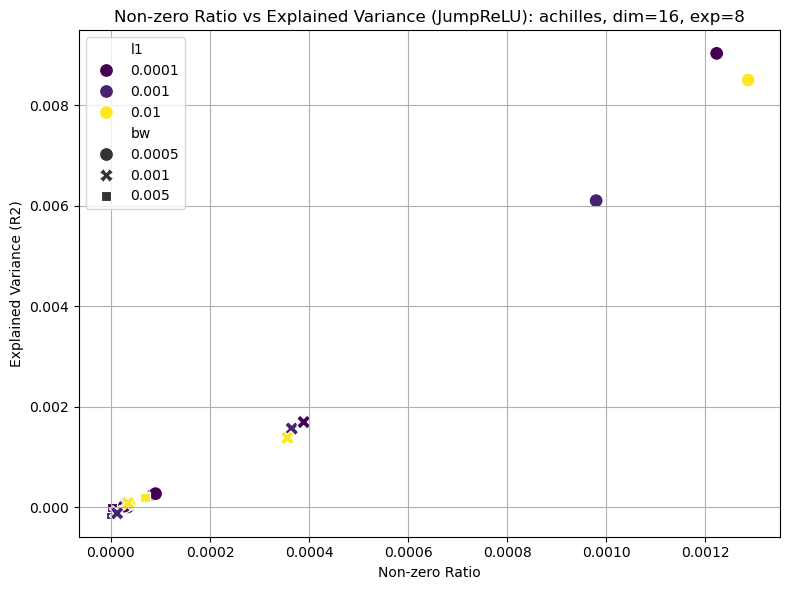

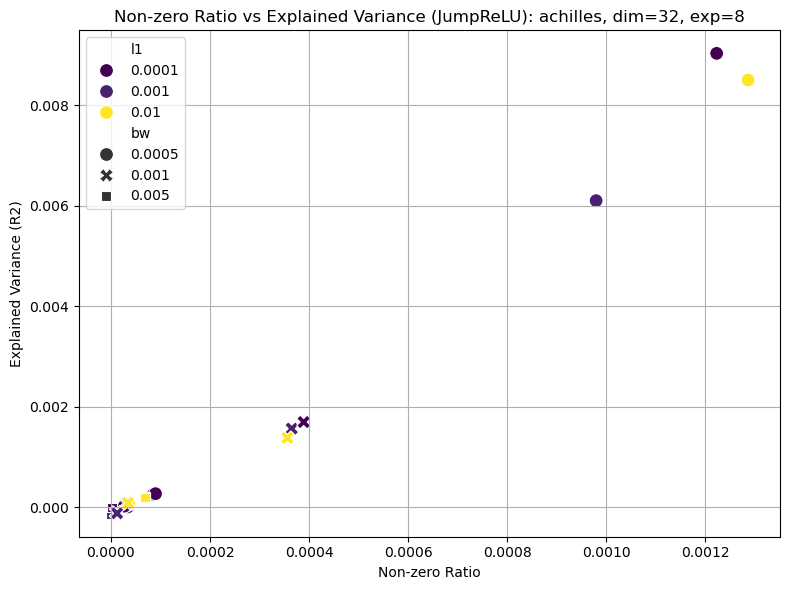

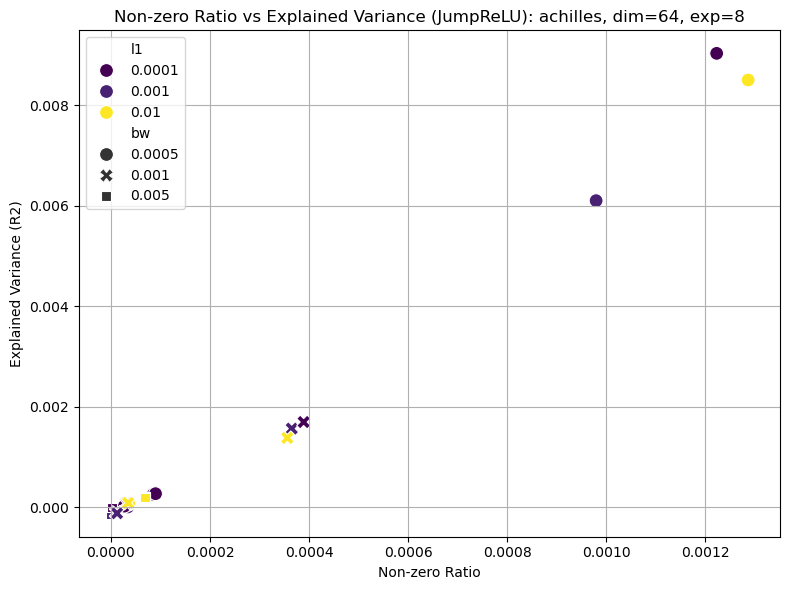

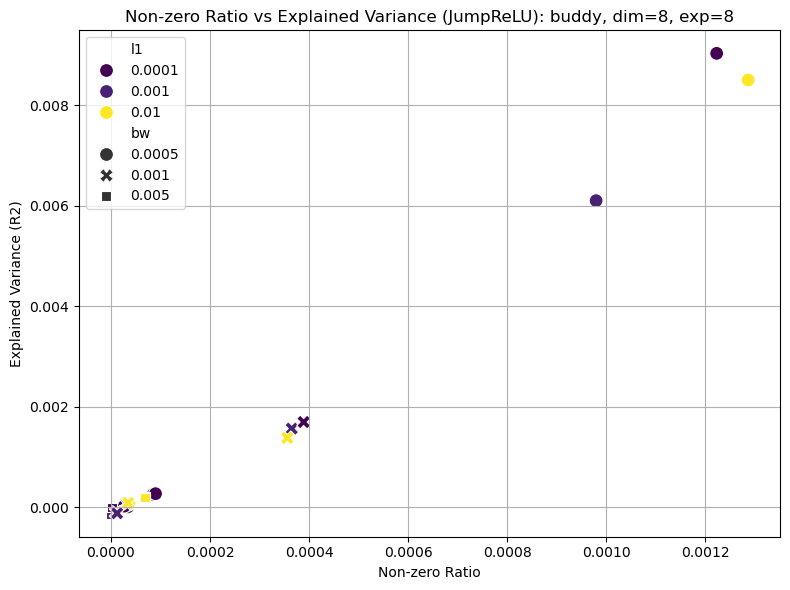

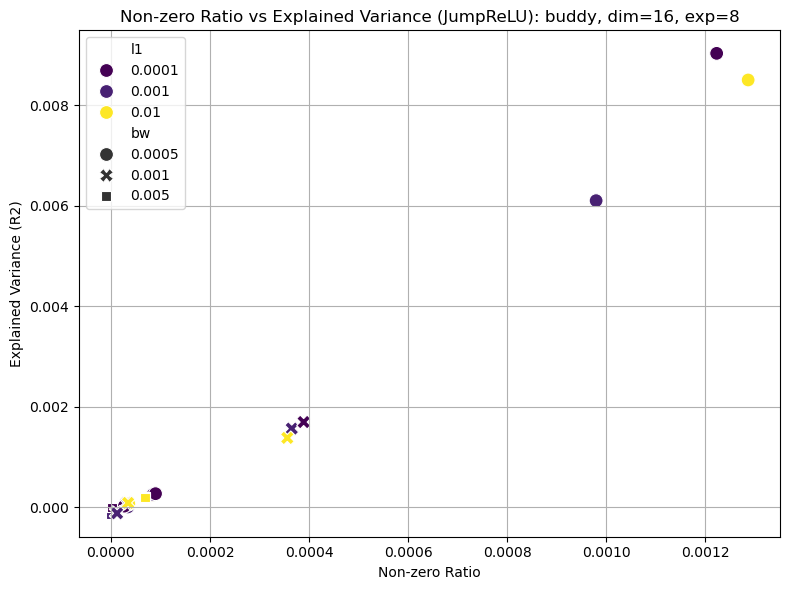

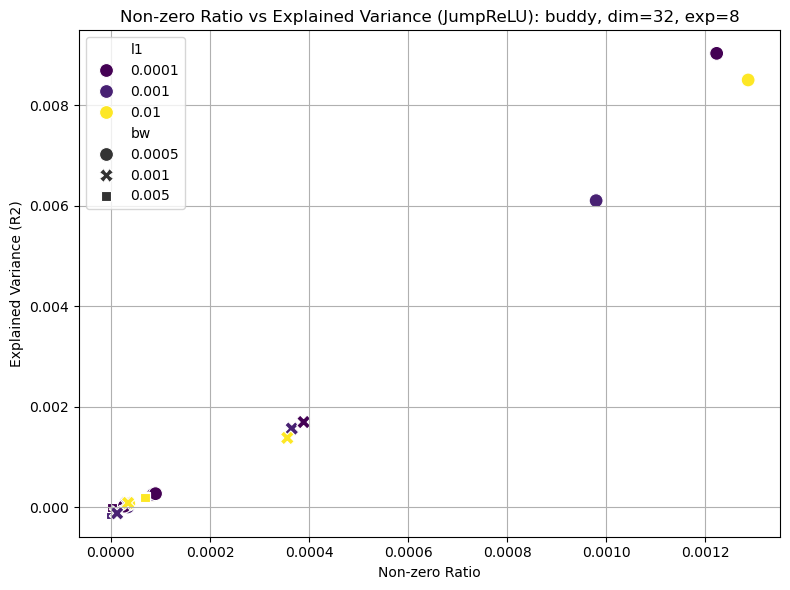

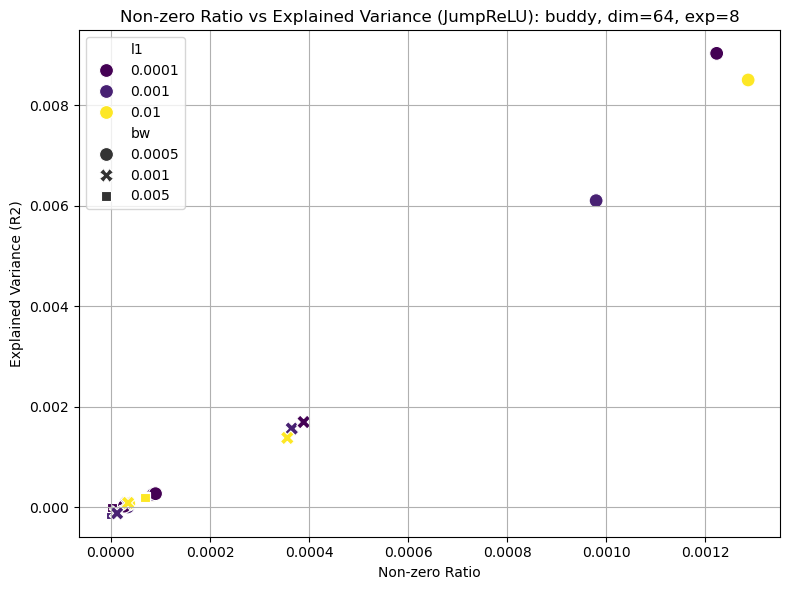

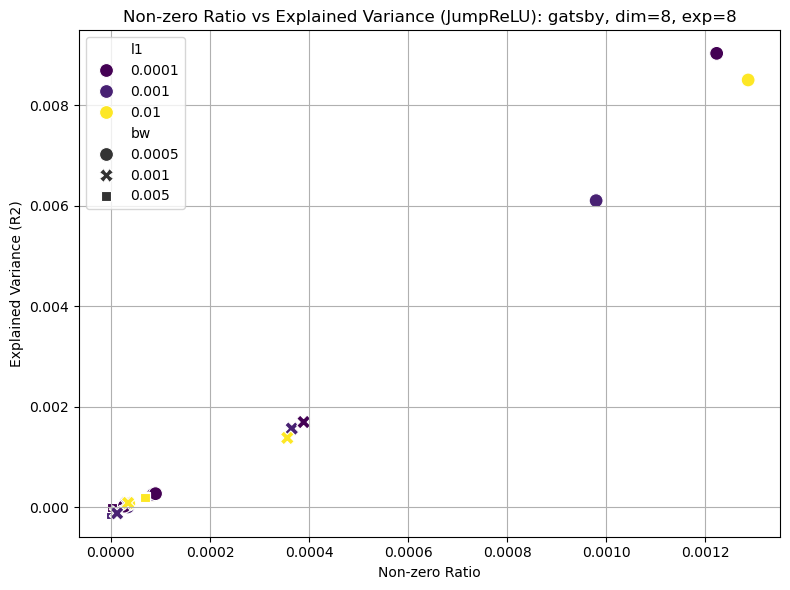

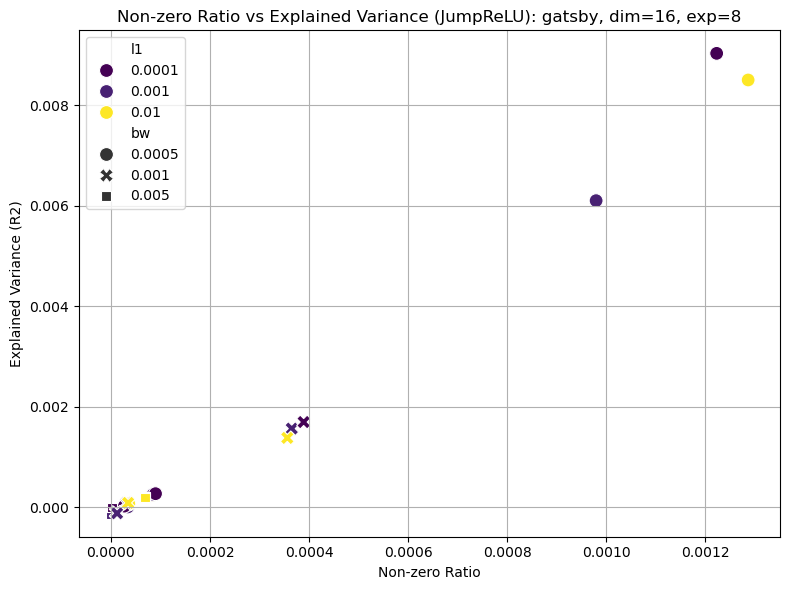

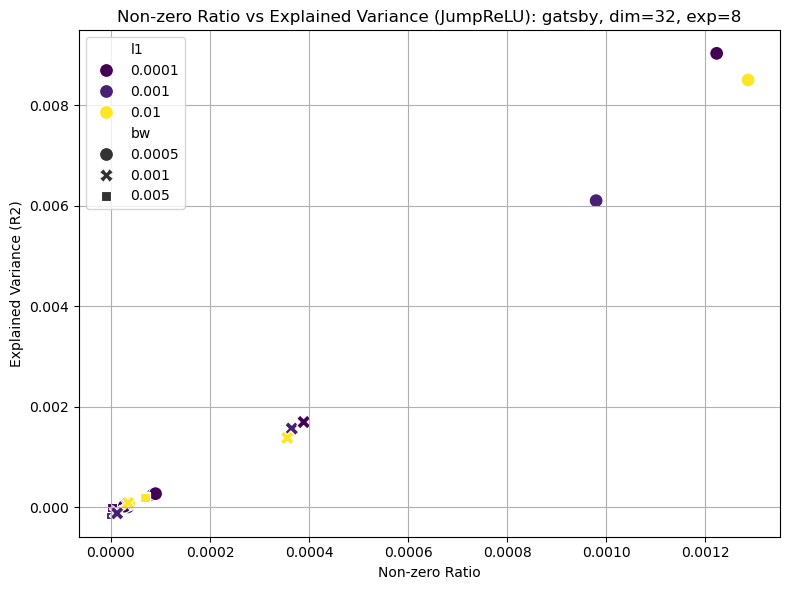

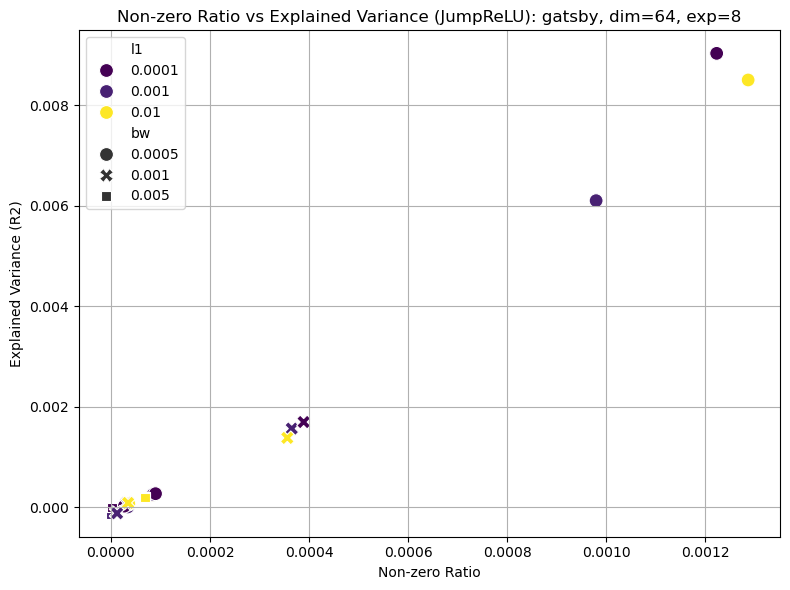

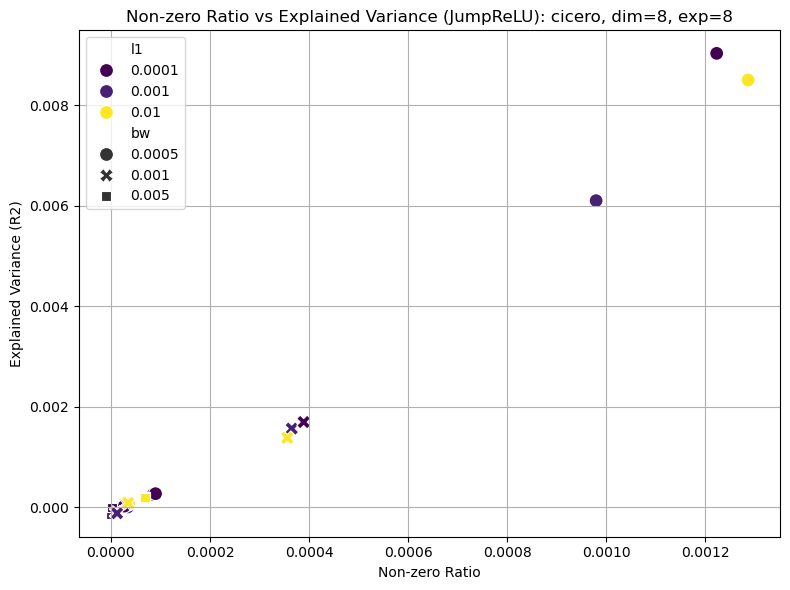

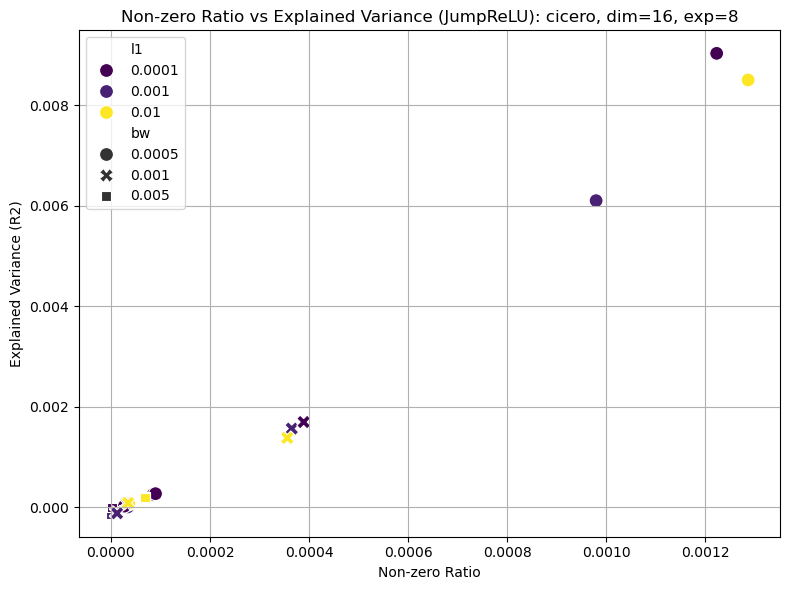

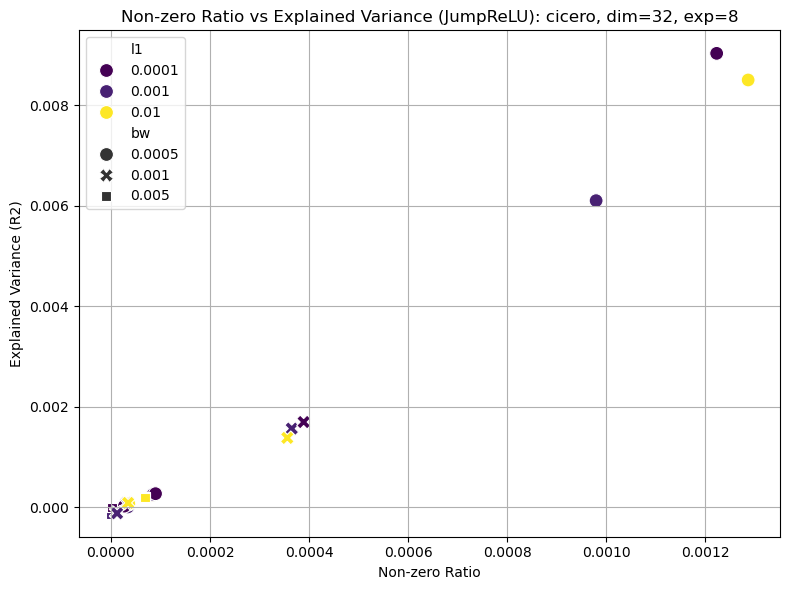

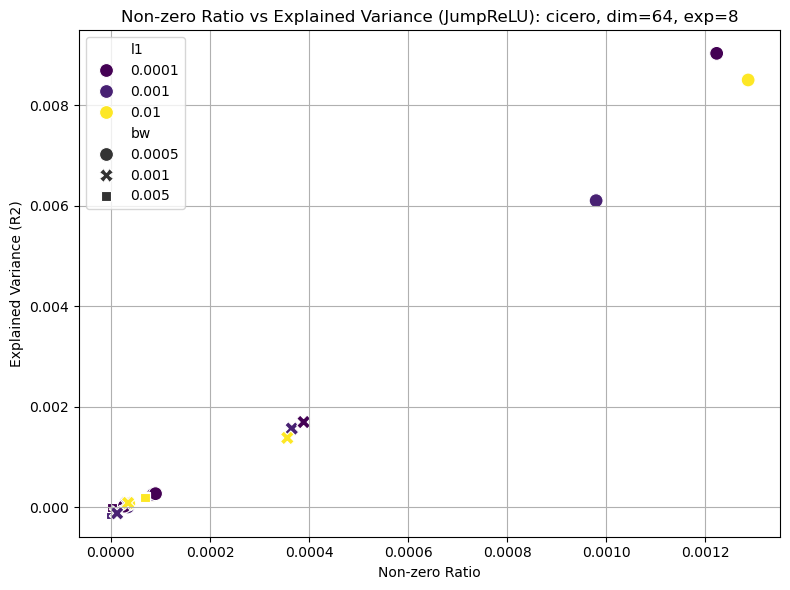

In [76]:
for name in names:
    for dim in dims:
        bw_selection_plot(name, dim)